In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from catboost import CatBoostClassifier
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, RidgeCV, Ridge
from sklearn.metrics import (accuracy_score, f1_score, mean_absolute_error, mean_absolute_percentage_error, 
                             mean_squared_error, precision_score, r2_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from ydata_profiling import ProfileReport

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_excel('dataset_model.xlsx')

In [3]:
report = ProfileReport(df, title='Описательныая статистика dataset_model')
report.to_file("stats_dataset_model.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:00<00:00, 750.14it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
df.describe()

,Age,Weight,Height,BMI,BSA,Pgradient_upper,isthmus_aorta_gradient,Pgradient_before,ascending_aorta_d_US,discending_aorta_d,Form,VPS,arch_anomaly,aorta_thorax_pathology,AH,blood_flow_characteristic,operation
count,344.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000
mean,19.232,53.225,157.285,24.181,2.961,4.186,59.722,52.314,27.515,18.447,1.166,0.230,0.029,0.259,0.779,1.238,1.230
std,13.131,23.031,90.805,31.987,15.274,5.783,16.877,18.846,5.977,3.588,0.372,0.421,0.168,0.439,0.415,0.447,0.421
min,2.100,13.000,53.000,0.213,0.600,0.000,10.000,0.000,3.300,10.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000
25%,10.000,35.000,140.000,17.805,1.180,0.000,50.000,40.000,26.000,18.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000
50%,13.900,52.000,155.000,20.707,1.500,5.000,60.000,50.000,27.000,18.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000
75%,26.375,70.000,170.000,24.935,1.843,5.000,70.000,65.000,28.000,18.000,1.000,0.000,0.000,1.000,1.000,1.000,1.000
max,66.000,134.000,1785.000,452.100,183.000,40.000,110.000,125.000,53.000,45.000,2.000,1.000,1.000,1.000,1.000,3.000,2.000


In [13]:
%matplotlib inline

<Figure size 2000x1000 with 0 Axes>

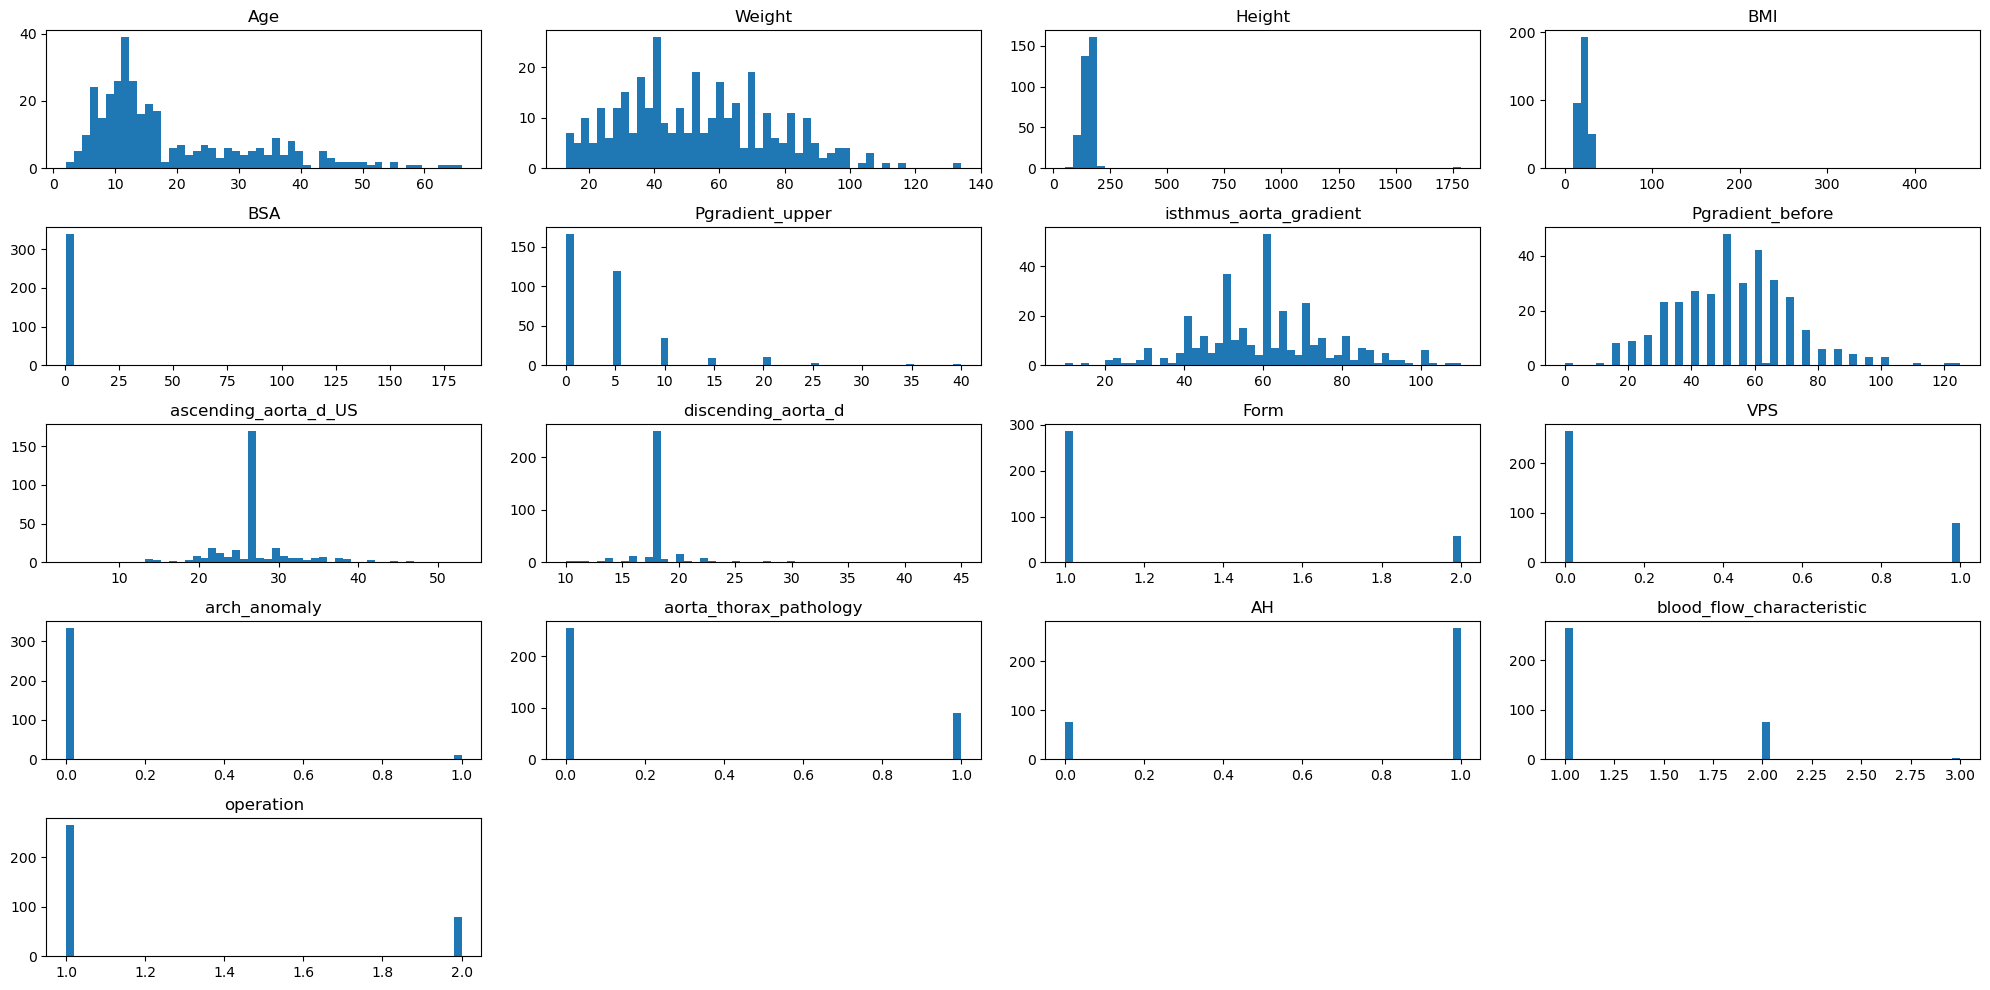

In [ ]:
# выведем гистограммы признаков
plt.figure(figsize=(20, 10))
df.hist(bins=50, grid=False, figsize=(20, 10))
plt.tight_layout()
plt.show()

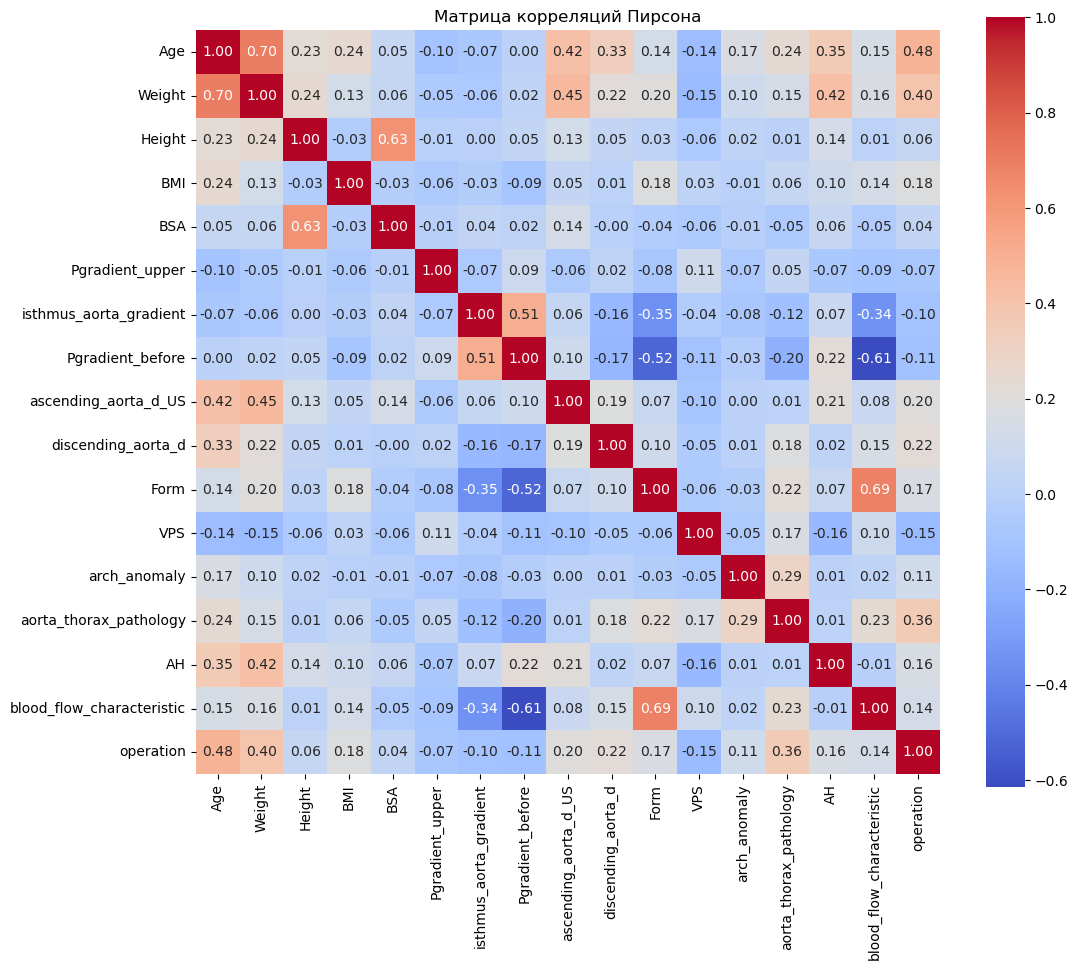

In [18]:
# матрица корреляций
corr_matrix = df.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Матрица корреляций Пирсона')
plt.show()

In [19]:
df['operation'].value_counts()

operation
1    265
2     79
Name: count, dtype: int64

In [ ]:
def binary_classification(df,
                          y,
                          best_metric="recall",
                          fold_cv=3,
                          plot_size=(10, 10),
                          class_weight_balanced=True,
                          plot_feature_importance=True,
                          DecisionTreeClassifier=DecisionTreeClassifier,
                          grid_space_tree=None,
                          feature_importance_tree=True,
                          RandomForestClassifier=RandomForestClassifier,
                          grid_space_forest=None,
                          feature_importance_forest=True,
                          LogisticRegression=LogisticRegression,
                          grid_space_log_reg=None,
                          feature_importance_log_reg=True,
                          CatBoostClassifier=CatBoostClassifier,
                          grid_space_catboost=None,
                          feature_importance_catboost=True,
                          SVC=SVC,
                          grid_space_svc=None,
                          feature_importance_svc=True,
                          RANDOM_STATE=21
                          ):
  """
  Функция для построения моделей машинного обучения.
  На вход требуется датафрейм df, содержащий в т.ч. таргет y (наименование столбца).
  fold_cv, best_metric - количество фолдов и метрика для поиска гиперпараметров по сетке.
  """
  
  features = df.drop(y, axis=1)
  target = df[y]
  scoring = ['roc_auc','f1','recall','precision']
  results = []

  def ml (algorithm, greed_space_model):
    """
    algorithm - название алгоритма машинного обучения.
    greed_space_model - пространство параметров для поиска оптимальной комбинации 
    гиперпараметров с помощью алгоритма GridSearch.
    """
    if class_weight_balanced == True and algorithm != CatBoostClassifier:
      model = algorithm(random_state=RANDOM_STATE, class_weight='balanced')

    elif class_weight_balanced == True and algorithm == CatBoostClassifier:
      model = algorithm(random_state=RANDOM_STATE, auto_class_weights='Balanced')

    elif algorithm == SVC:
      model = algorithm(random_state=RANDOM_STATE, probability=True)

    else:
      model = algorithm(random_state=RANDOM_STATE)

    grid = GridSearchCV(model,
                      param_grid=greed_space_model,
                      cv=fold_cv,
                      scoring=scoring,
                      refit=best_metric
                      )

    model_fit = grid.fit(features,
                         target)

    model_results = (pd
                     .DataFrame(model_fit.cv_results_)
                     .query('mean_test_'+ best_metric + ' == mean_test_' + best_metric + '.max()')
                     .reset_index())

    metrics_results = pd.DataFrame({algorithm:[model_results.loc[0,'mean_test_f1'],
                                               model_results.loc[0,'mean_test_roc_auc'],
                                               model_results.loc[0,'mean_test_recall'],
                                               model_results.loc[0,'mean_test_precision'],
                                               ]},
                                    index = ['f1','roc_auc','recall','precision'])

    return metrics_results.T, model_fit

  def f_importances(coef, names, title):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=plot_size)
    plt.title(title)
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.grid(visible=True)
    plt.show()
    """
    Функция для вывода графика относительной важности coef признаков names модели с заголовком title.
    """

  if DecisionTreeClassifier != None:

    if grid_space_tree == None:
      tree, model_fit = ml(DecisionTreeClassifier, 
                           {'max_features':['sqrt','log2', None],
                            'criterion':['gini','entropy','log_loss']
                            })
    else:
      tree, model_fit = ml(DecisionTreeClassirfier, grid_space_tree)

    tree.index = ['Tree']
    results.append(tree)

    if plot_feature_importance and feature_importance_tree:
      f_importances(model_fit.best_estimator_.feature_importances_,
                  features.columns,
                  'Важность признаков для алгоритма DecisionTreeClassifier')

  if RandomForestClassifier != None:

    if grid_space_forest == None:
      forest, model_fit = ml(RandomForestClassifier, 
                             {'max_features':['sqrt','log2', None],
                              'criterion':['gini','entropy','log_loss']
                              })
    else:
      forest, model_fit = ml(RandomForestClassifier, grid_space_forest)

    forest.index = ['Forest']
    results.append(forest)

    if plot_feature_importance and feature_importance_forest:
       f_importances(model_fit.best_estimator_.feature_importances_,
                  features.columns,
                  'Важность признаков для алгоритма RandomForestClassifier')

    best_forest = model_fit.best_estimator_
    dump(best_forest, 'forest.pkl')


  if LogisticRegression != None:

    if grid_space_log_reg == None:
      log_reg, model_fit = ml(LogisticRegression, 
                              {'max_iter':[100, 200, 300],
                               'C':[0.1, 0.3, 0.5 , 0.7, 1, 1.5, 2]
                               })
    else:
      log_reg, model_fit = ml(LogisticRegression, grid_space_log_reg)

    log_reg.index = ['LogReg']
    results.append(log_reg)

    if plot_feature_importance and feature_importance_log_reg:
      f_importances(model_fit.best_estimator_.coef_[0],
                  features.columns,
                  'Важность признаков для алгоритма LogisticRegression')
    best_logreg = model_fit.best_estimator_
    dump(best_logreg, 'logreg.pkl')

  if CatBoostClassifier != None:

    if grid_space_catboost == None:
      cat, model_fit = ml(CatBoostClassifier, 
                          {'n_estimators':[100, 200, 300],
                           'verbose':[False]
                           })
    else:
      cat, model_fit = ml(CatBoostClassifier, grid_space_catboost)

    cat.index = ['CatBoost']
    results.append(cat)

    if plot_feature_importance and feature_importance_catboost:
      f_importances(model_fit.best_estimator_.feature_importances_,
                  features.columns,
                  'Важность признаков для алгоритма CatBoostClassifier')
    best_catboost = model_fit.best_estimator_
    best_catboost.save_model('catboost', format='cbm')

  if SVC != None:

    if grid_space_svc == None:
      svc, model_fit = ml(SVC,
                          {'C':[0.5, 1, 5, 10],
                           'kernel':['linear']
                           })

    else:
      svc, model_fit = ml(SVC, grid_space_svc)

    svc.index = ['SVC']
    results.append(svc)

    if plot_feature_importance and feature_importance_svc:
      f_importances(model_fit.best_estimator_.coef_[0],
                  features.columns,
                  'Важность признаков для алгоритма SVC')
    best_svc = model_fit.best_estimator_
    dump(best_svc, 'svc.pkl')

  return pd.concat(results).sort_values(by=best_metric,ascending=False)

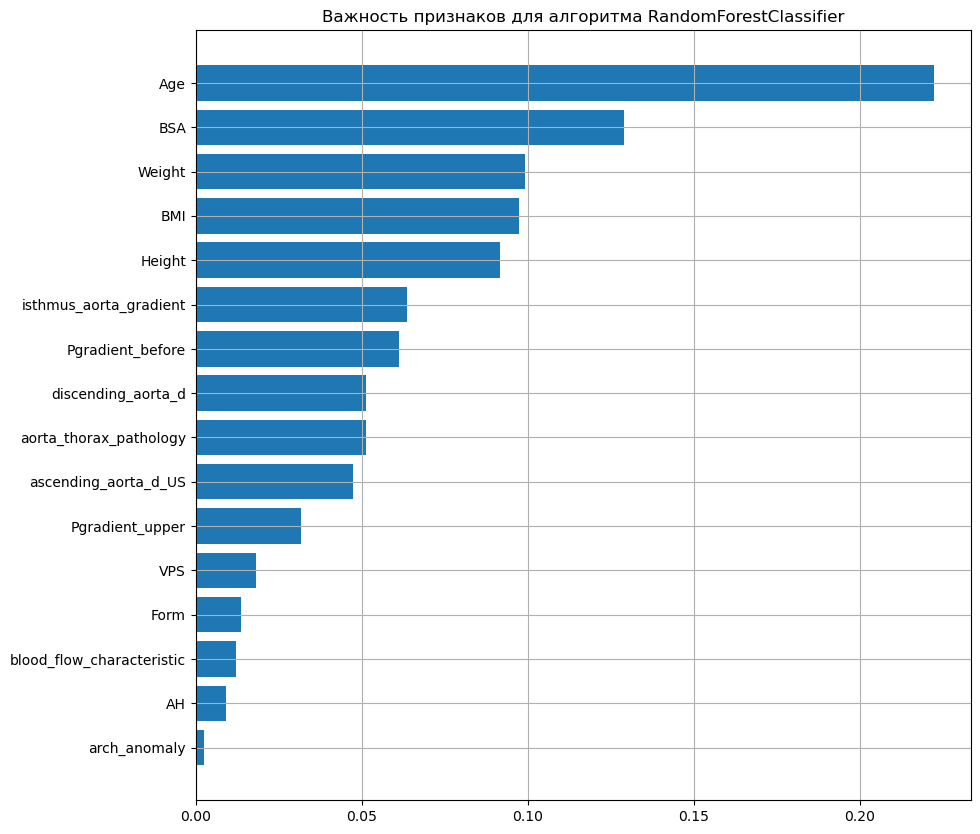

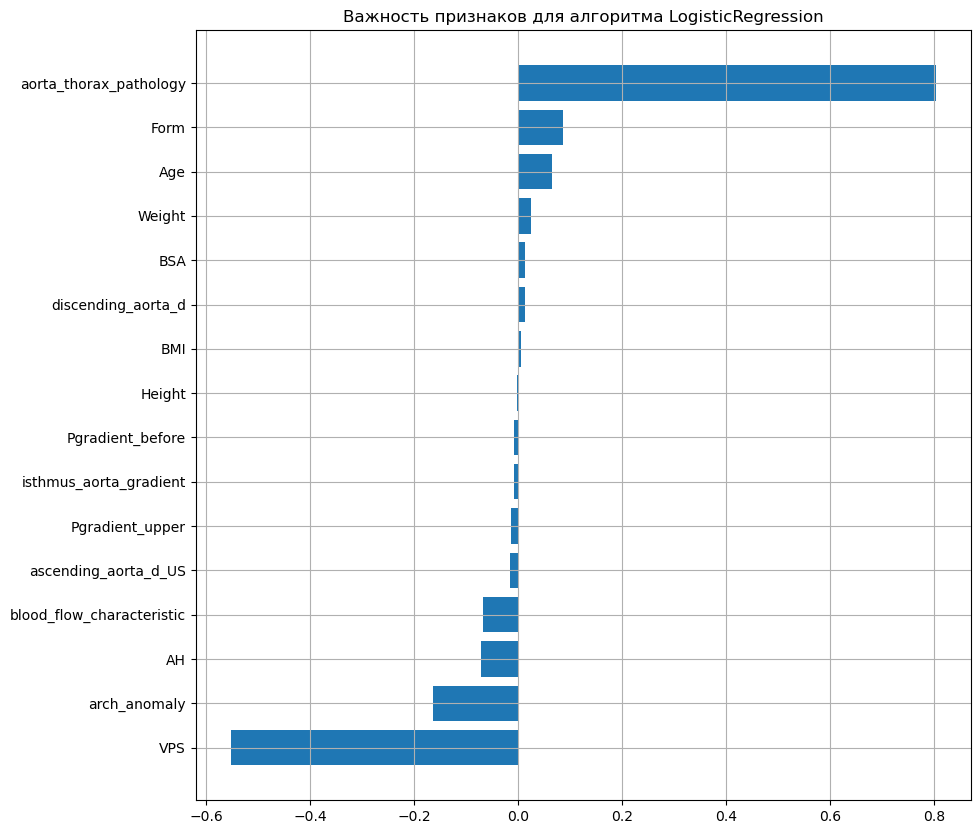

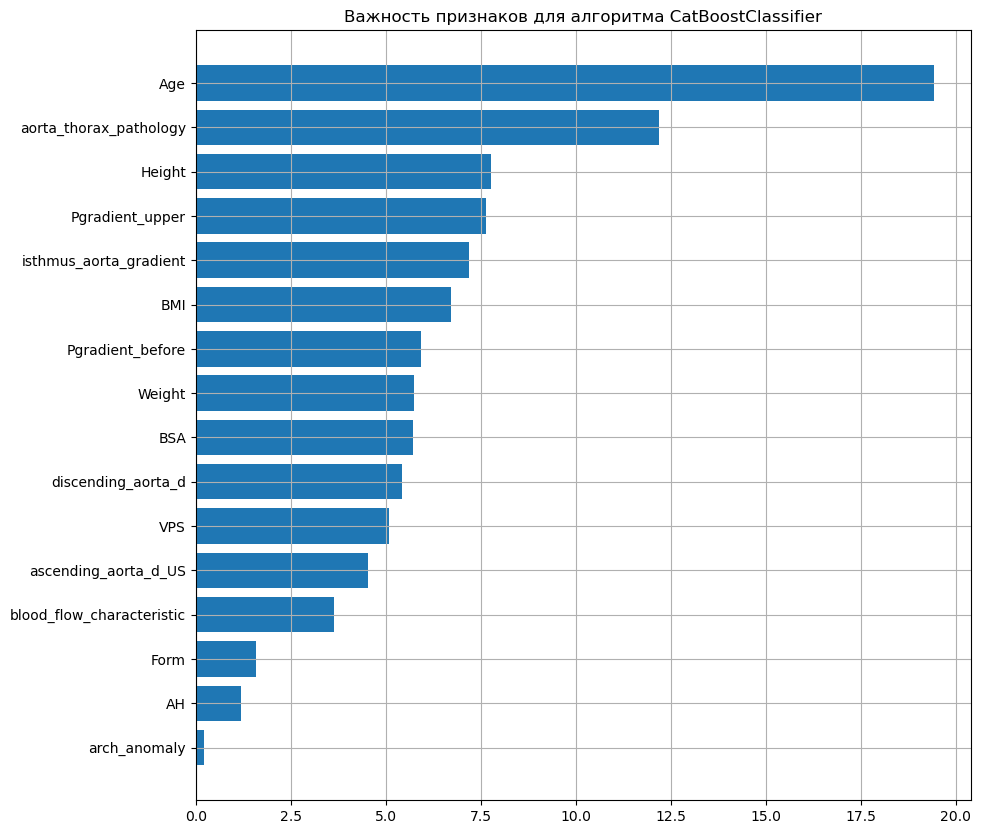

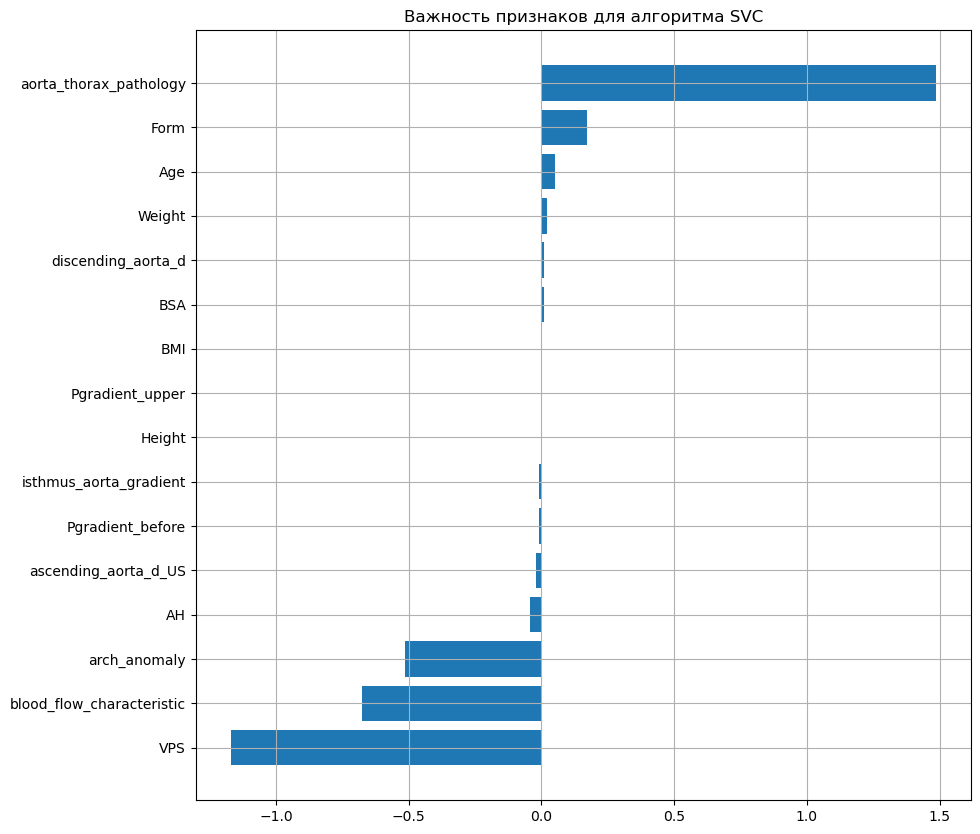

,f1,roc_auc,recall,precision
Forest,0.881,0.821,0.932,0.837
CatBoost,0.862,0.845,0.838,0.890
LogReg,0.844,0.814,0.793,0.907
SVC,0.822,0.815,0.759,0.904


In [27]:
binary_classification(df,
                      y='operation',
                      best_metric='recall',
                      plot_feature_importance=True,
                      DecisionTreeClassifier=None,
                      feature_importance_catboost=True
                      )